In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.rnn import RNN
#from src.models.som import SOM
from src.models.enc_pyod import AutoEnc
from src.models.mo_gaal import MGAAL
from src.models.multiple_models_pyod import SU_OD
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ecod import ECOD

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [5]:
#df = pd.read_excel('./SWAT/SWaT.A4 _ A5_Jul 2019/SWaT_dataset_Jul 19 v2.xlsx', skiprows=1)
df = pd.read_excel('SWaT_dataset_Jul 19 v2.xlsx', skiprows=1)
df = df.iloc[1:]
df = df.replace({'Active': 1, 'Inactive': 0})
df['time'] = pd.to_datetime(df['GMT +0'])
df.index = df['time'] + pd.to_timedelta('8H')
df = df.drop(['GMT +0', 'time'], axis=1)
df

,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
time,,,,,,,,,,,,,,,,,,,,,
2019-07-20 12:30:00+00:00,0.000000,729.865800,1,3,2,1,142.527557,9.293002,198.077423,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:01+00:00,0.000000,729.434000,1,3,2,1,142.527557,9.293002,198.385025,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:02.004013+00:00,0.000000,729.120000,1,3,2,1,142.527557,9.293002,198.436300,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:03.004013+00:00,0.000000,728.688200,1,3,2,1,142.527557,9.289157,198.667000,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:04+00:00,0.000000,727.706900,1,3,2,1,142.527557,9.289157,198.897720,2.335437,...,1,1,0,0,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-20 16:39:55.001007+00:00,4.200429,491.169769,2,2,2,1,131.408615,9.319918,257.703156,2.316086,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 16:39:56.005004800+00:00,4.253915,491.405273,2,2,2,1,131.408615,9.317354,257.703156,2.314292,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 16:39:57.005004800+00:00,4.303558,492.308100,2,2,2,1,131.408615,9.317354,257.703156,2.313651,...,1,1,0,0,0,1,2,1,1,1


In [6]:
data_train = df[:'2019-07-20 14:50:00']

data_test = df['2019-07-20 14:50:00':]
anomaly_time = [['2019-07-20 15:08:46','2019-07-20 15:10:31'],
                ['2019-07-20 15:15:00', '2019-07-20 15:19:32'],
                ['2019-07-20 15:26:57', '2019-07-20 15:30:48'],
                ['2019-07-20 15:38:50', '2019-07-20 15:46:20'],
                ['2019-07-20 15:54:00', '2019-07-20 15:56:00'],
                ['2019-07-20 16:02:56', '2019-07-20 16:16:18']]

data_test['anomaly'] = 0
for anomaly_range in anomaly_time:
    data_test['anomaly'].loc[anomaly_range[0]:anomaly_range[1]] = 1
    

In [7]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index([], dtype='object')

deleting constant features: ['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']


In [8]:
summary = {}

## Подготовка train/test

In [9]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


## OC SVM

In [23]:
description='SWATJuj19_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-13 22:19:10.364325: find saved model: ./saved_models/SWATJuj19_svm_default, loading...


SWATJuj19_svm_default
f1_score: 0.49
accuracy_score: 0.50
precision_score: 0.35
recall_score: 0.81


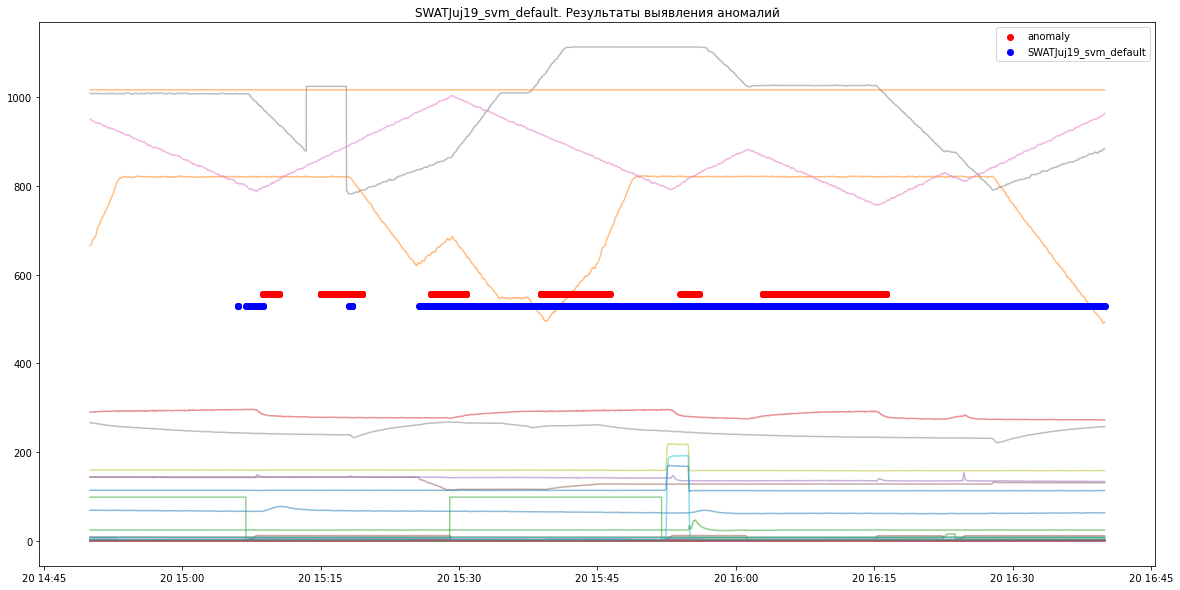

In [24]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-13 22:19:16.878176: find saved model: ./saved_models/SWATJuj19_svm_minmax, loading...
SWATJuj19_svm_minmax
f1_score: 0.54
accuracy_score: 0.52
precision_score: 0.38
recall_score: 0.93


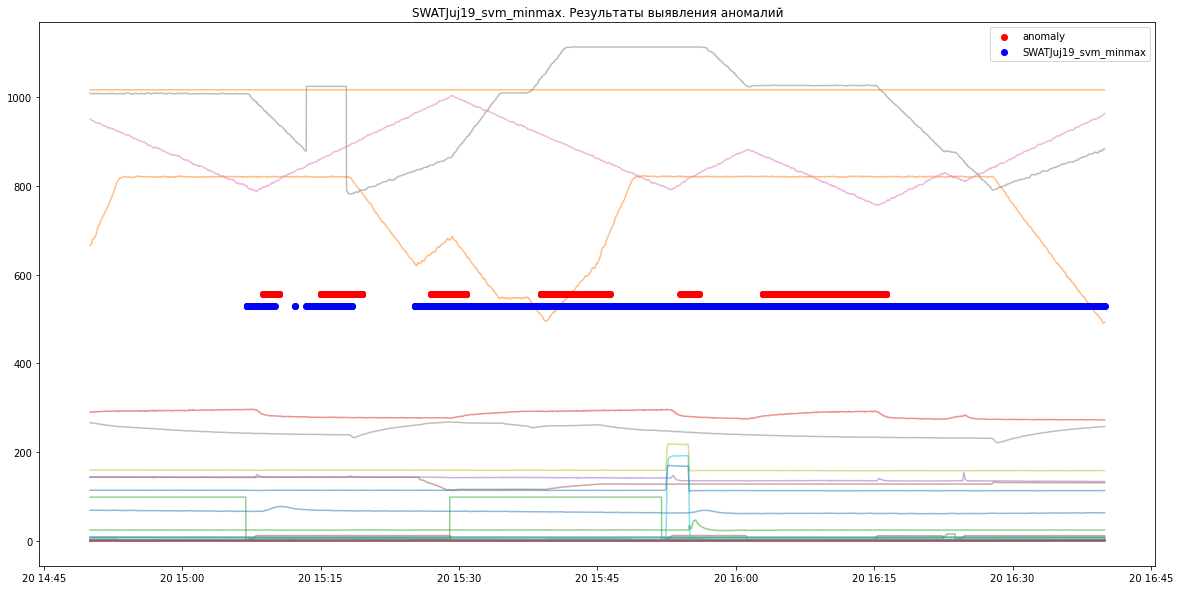

In [25]:
description='SWATJuj19_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [26]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [27]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


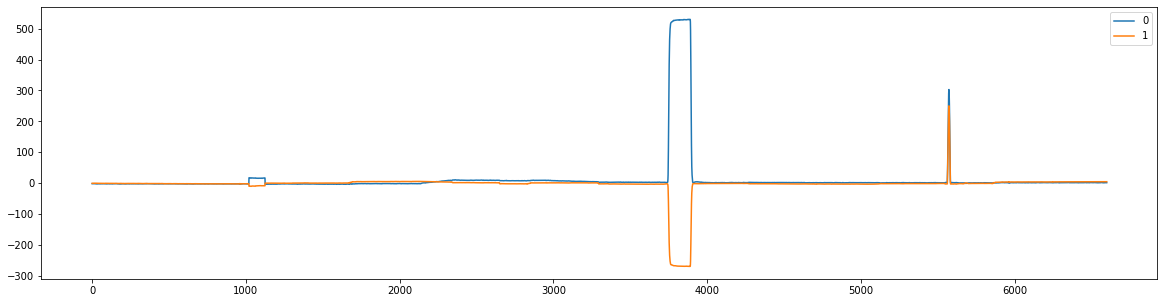

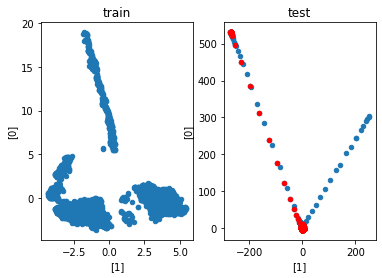

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

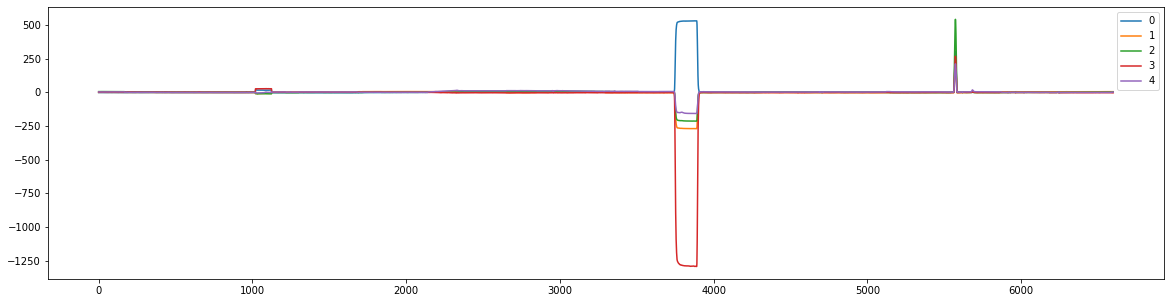

In [30]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [31]:
model = LOF()

In [ ]:
description = f'SWATJuj19_lof_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-13 22:27:11.762306: find saved model: ./saved_models/SWATJuj19_iF_default, loading...
SWATJuj19_iF_default
f1_score: 0.00
accuracy_score: 0.70
precision_score: 0.00
recall_score: 0.00


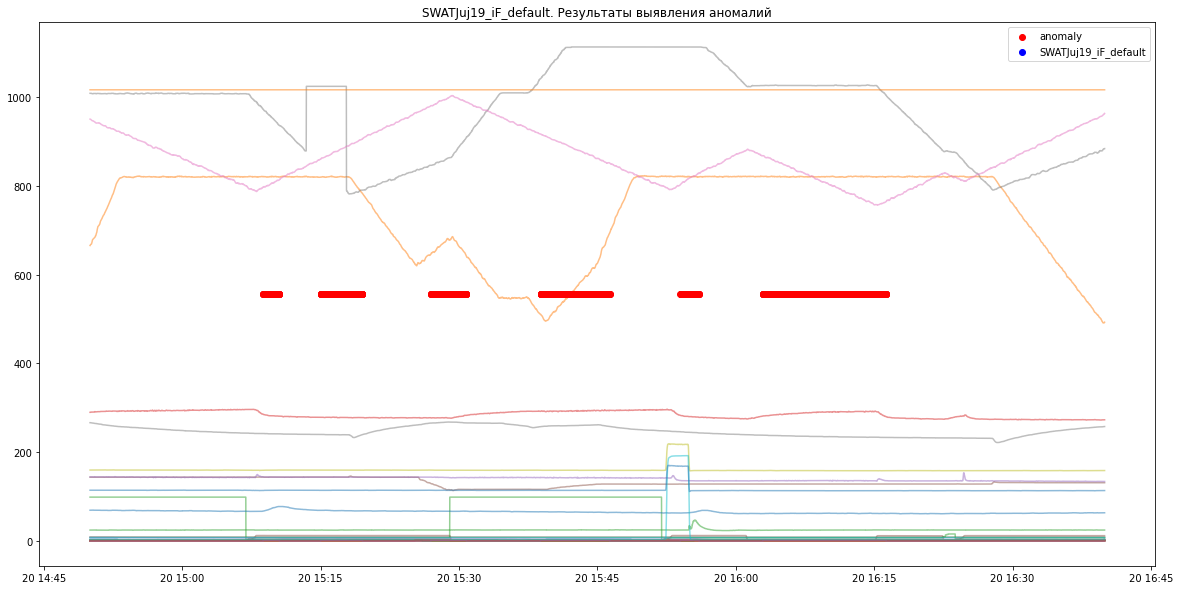

In [35]:
description = f'SWATJuj19_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-13 22:27:17.054008: refit model...
SWATJuj19_iF_n_200_c_01
f1_score: 0.52
accuracy_score: 0.53
precision_score: 0.38
recall_score: 0.83


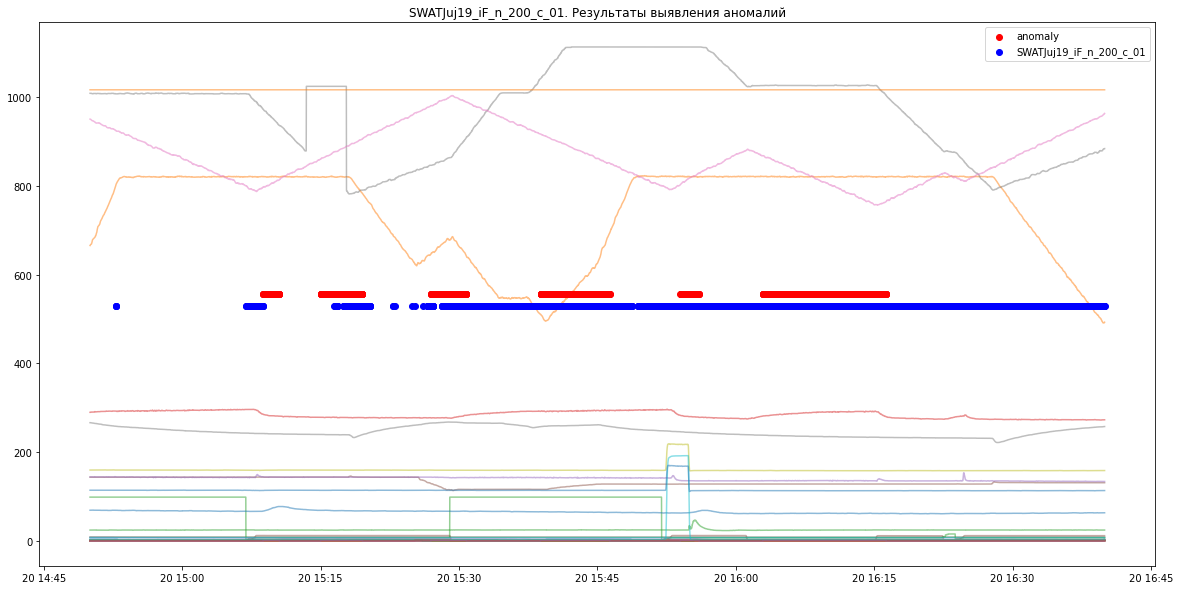

In [36]:
description = f'SWATJuj19_iF_n_200_c_01'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=200, contamination=0.1)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Create sequences with window size 30...
Размеры выборок:
            x_train: (8368, 30, 44)
            x_test: (6571, 30, 44)
            y_test: (6571, 30)
2022-09-13 22:28:04.875848: can't find saved model, fit model...
Epoch 1/10
9/9 [==============================] - 16s 786ms/step - loss: 3.3144
Epoch 2/10
9/9 [==============================] - 7s 798ms/step - loss: 1.0197
Epoch 3/10
9/9 [==============================] - 7s 807ms/step - loss: 0.9106
Epoch 4/10
9/9 [==============================] - 7s 800ms/step - loss: 0.7340
Epoch 5/10
9/9 [==============================] - 7s 825ms/step - loss: 0.6547
Epoch 6/10
9/9 [==============================] - 8s 869ms/step - loss: 0.5700
Epoch 7/10
9/9 [==============================] - 7s 790ms/step - loss: 0.5011
Epoch 8/10
9/9 [==============================] - 7s 823ms/step - loss: 0.4361
Epoch 9/10
9/9 [==============================] - 8s 859ms/step -

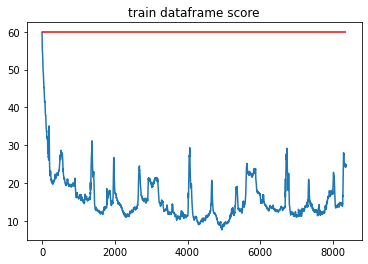

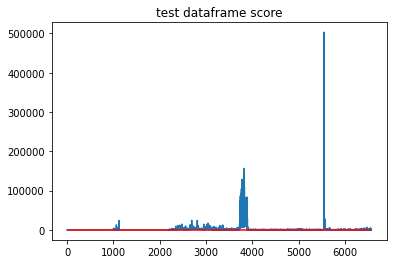

(6571,)
SWATJuj19_ae_lstm_window_30_resample_None
f1_score: 0.49
accuracy_score: 0.49
precision_score: 0.35
recall_score: 0.81


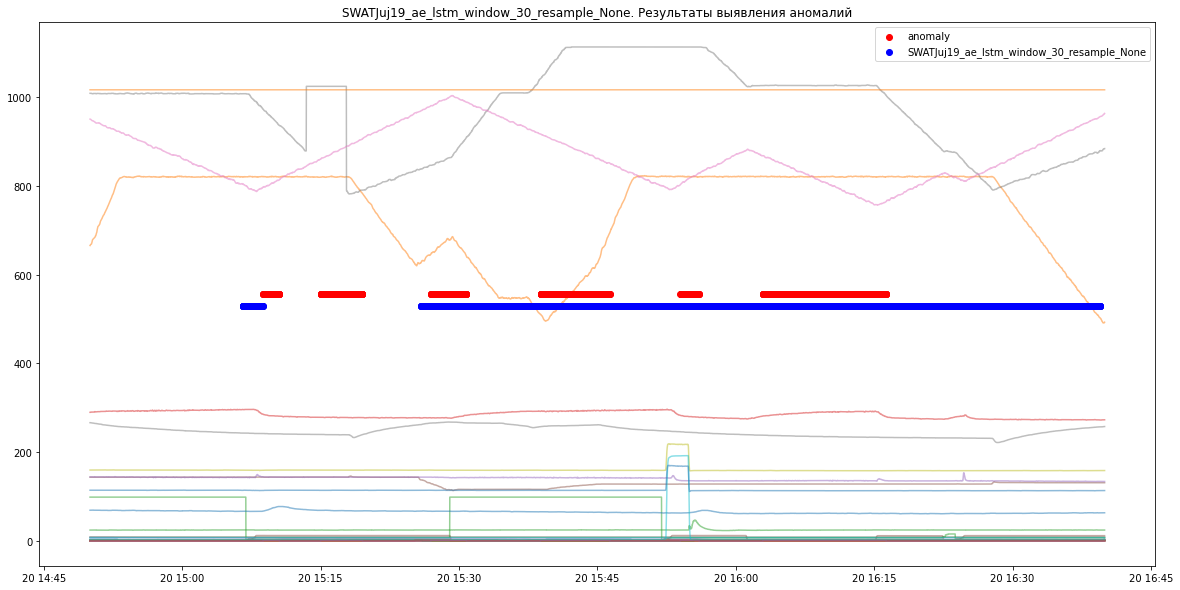

In [38]:
window_size = 30
resample_rate = None

description = f'SWATJuj19_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## SOM

In [ ]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 69.9%

Counter({1: 4614, 0: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


2022-08-28 21:38:48.067205: can't find saved model, fit model...
50000


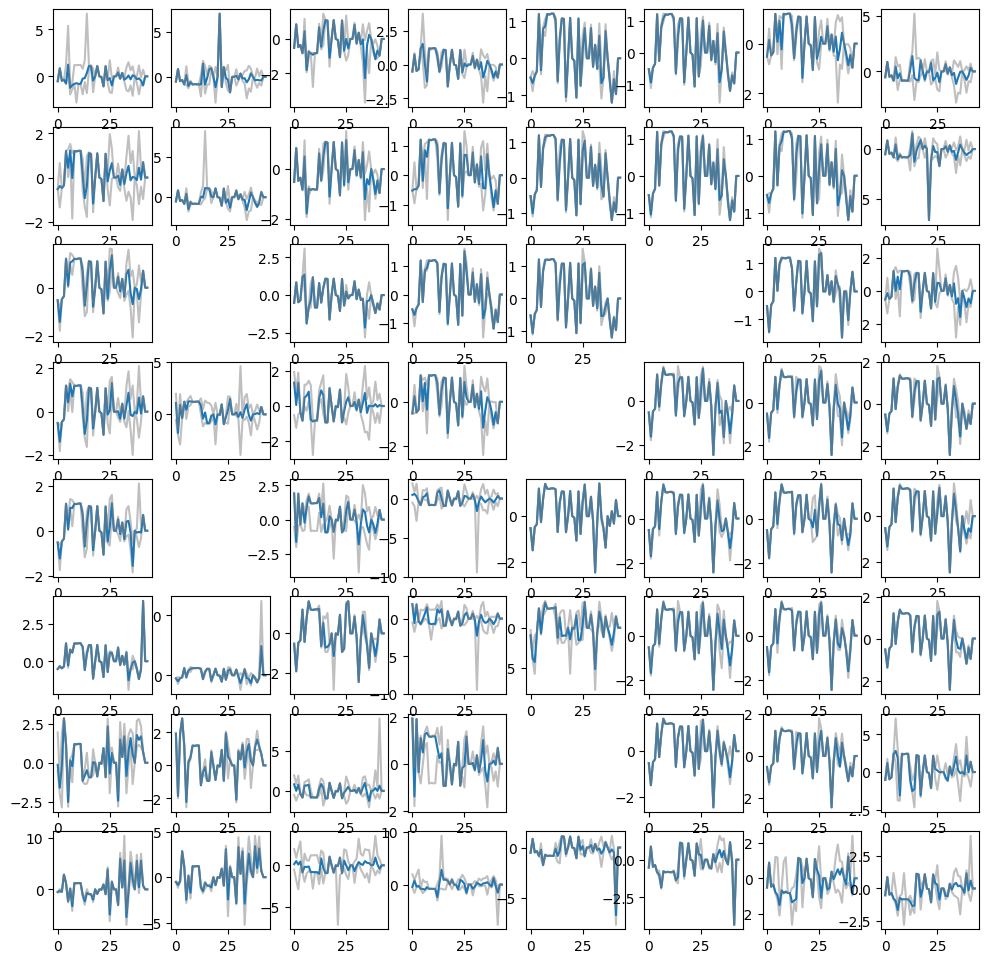

IntProgress(value=0, description='Computing', max=6600, style=ProgressStyle(bar_color='#61dc8a'))

IntProgress(value=0, description='Computing', max=8397, style=ProgressStyle(bar_color='#61dc8a'))

Train prediction score statistics
            min: 2.2086825592205805
            mean: 58.08780465832778
            max: 131.5751860522342


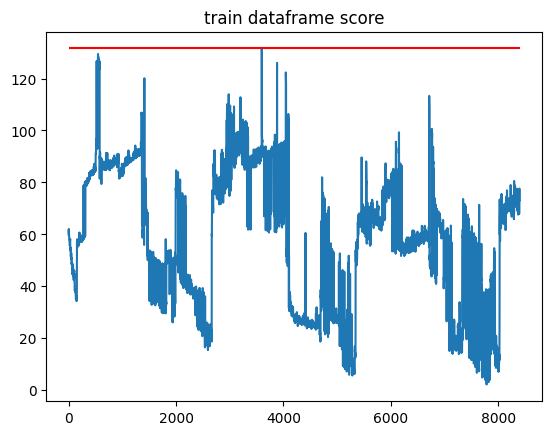

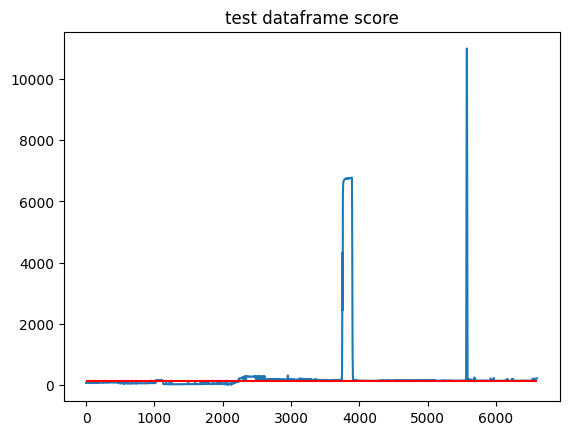

(6600,)
SWATJuj19_som_default
f1_score: 0.63
accuracy_score: 0.50
precision_score: 0.64
recall_score: 0.62


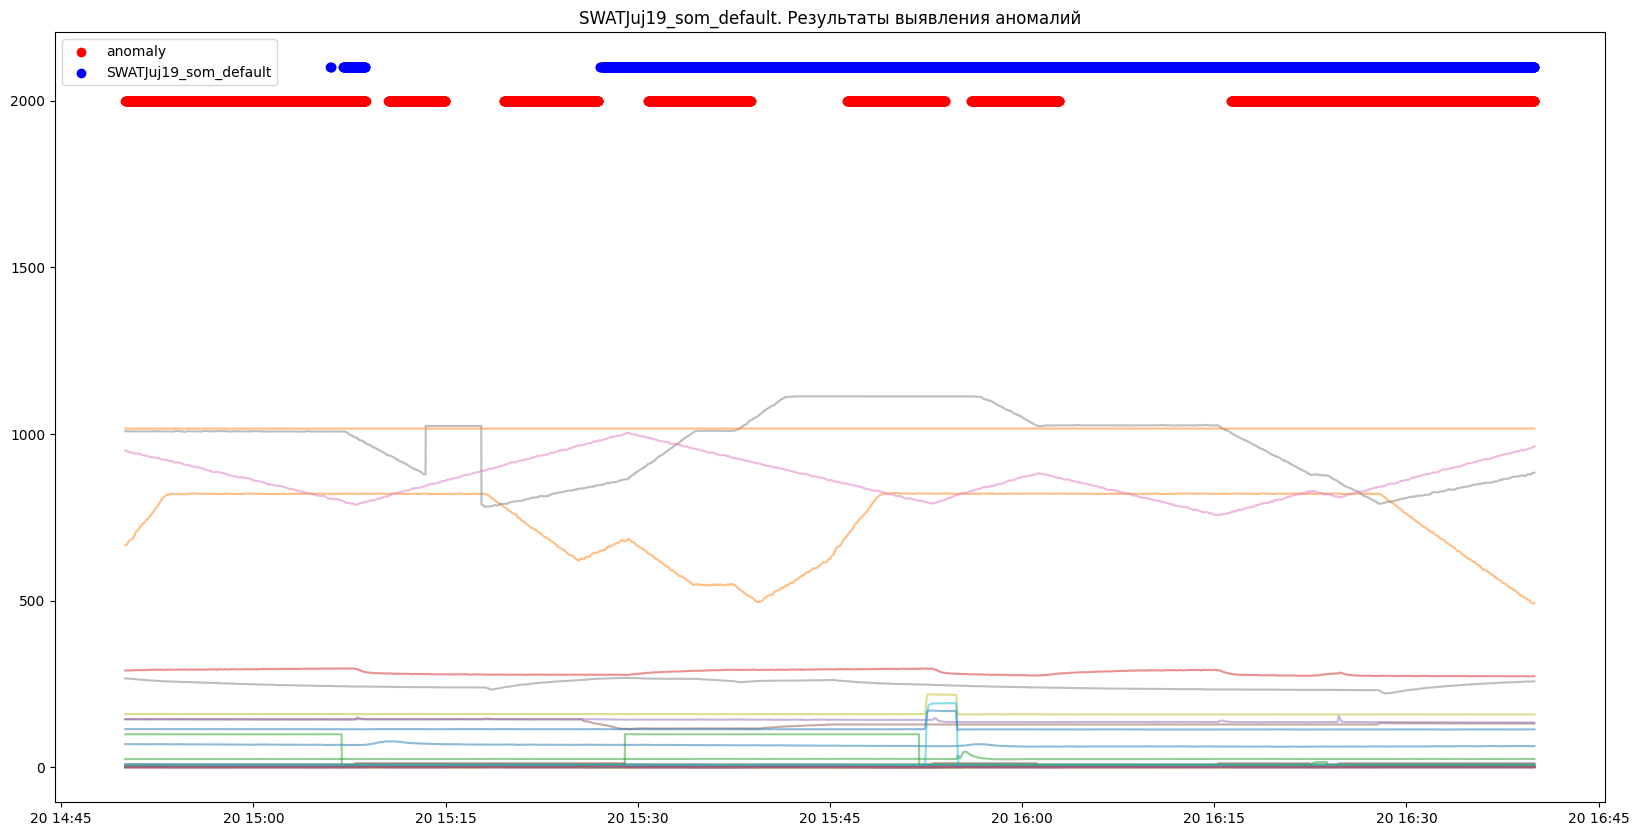

In [ ]:
description = f'SWATJuj19_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## AutoEncoder in pyod

In [39]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 44)                1980      
                                                                 
 dropout (Dropout)           (None, 44)                0         
                                                                 
 dense_2 (Dense)             (None, 44)                1980      
                                                                 
 dropout_1 (Dropout)         (None, 44)                0         
                                                                 
 dense_3 (Dense)             (None, 8397)              377865    
                                                                 
 dropout_2 (Dropout)         (None, 8397)              0         
                                                                 
 dense_4 (Dense)             (None, 25)               

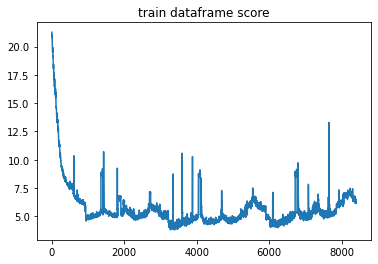

207/207 [==============================] - 2s 9ms/step


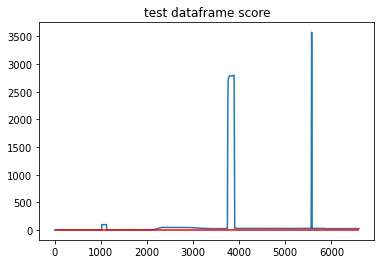

SWATjul9_AutoEncoder_pyod
f1_score: 0.51
accuracy_score: 0.50
precision_score: 0.36
recall_score: 0.85


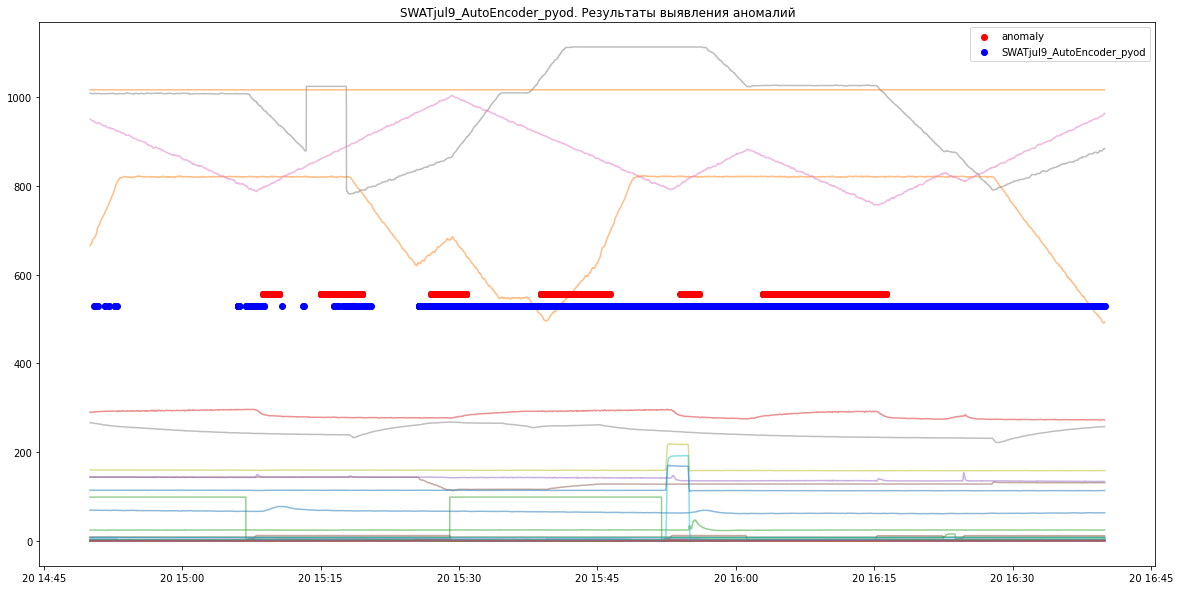

In [40]:
description = f'SWATjul9_AutoEncoder_pyod'

model = AutoEnc(x_train, epochs=10)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies(threshold=6.5)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:], y_pred, descr=description)

## MO_GAAL in pyod

In [41]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


Epoch 1 of 6

Testing for epoch 1 index 1:
263/263 [==============================] - 1s 4ms/step

Testing for epoch 1 index 2:
263/263 [==============================] - 1s 4ms/step

Testing for epoch 1 index 3:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 4:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 5:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 6:
263/263 [==============================] - 1s 4ms/step

Testing for epoch 1 index 7:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 8:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 9:
263/263 [==============================] - 1s 3ms/step

Testing for epoch 1 index 10:
263/263 [==============================] - 1s 4ms/step

Testing for epoch 1 index 11:
263/263 [==============================] - 1s 4ms/step

Testing for epoch 1 index 12:
263/263 [==========

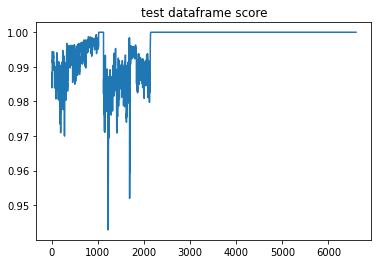

SWATjul9_MO_GAAL_pyod
f1_score: 0.47
accuracy_score: 0.43
precision_score: 0.33
recall_score: 0.84


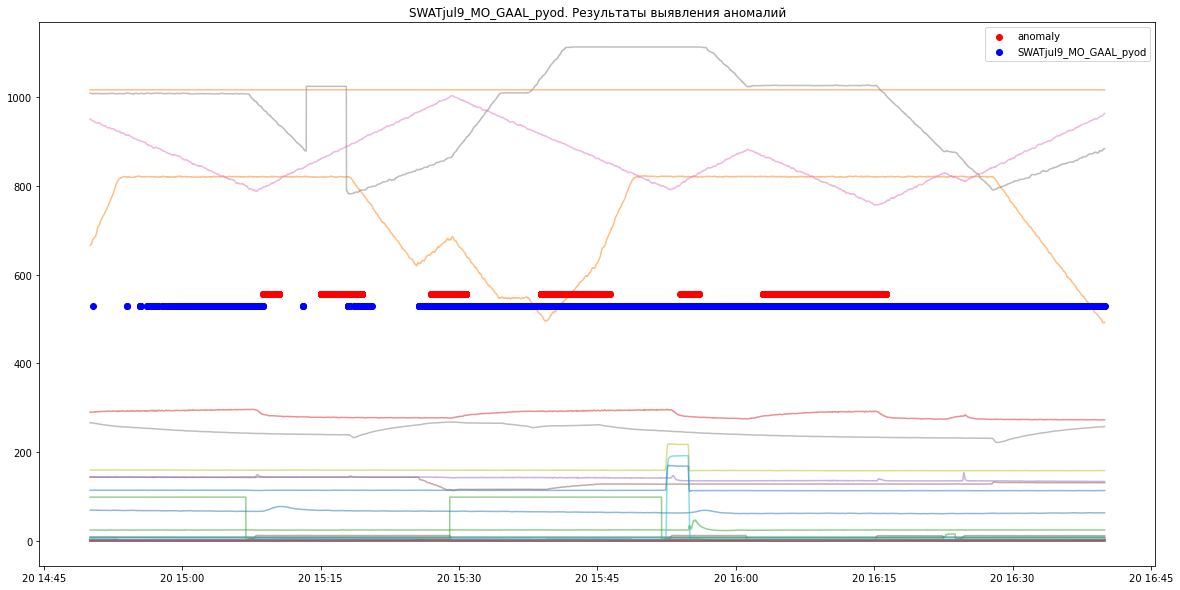

In [42]:
description = f'SWATjul9_MO_GAAL_pyod'

model = MGAAL()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Multiple models with pyod

In [43]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


Worker 1 sum of ranks: 5.4
Worker 2 sum of ranks: 2.6

Split among workers BPS: [0, 3, 5] [3, 2]
Parallel Training...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.4s finished


Balanced Scheduling Total Train Time: 11.59750485420227
Split among workers default: [3 5] [2]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   48.0s finished


Worker 1 sum of ranks: 5.4
Worker 2 sum of ranks: 2.6

Split among workers BPS: [0, 3, 5] [3, 2]
Parallel Training...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.3s finished


Balanced Scheduling Total Train Time: 7.761289358139038
Split among workers default: [3 5] [2]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.8min finished


Worker 1 sum of ranks: 5.4
Worker 2 sum of ranks: 2.6

Split among workers BPS: [0, 3, 5] [3, 2]
Parallel score prediction...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: 7.552366495132446
Worker 1 sum of ranks: 5.4
Worker 2 sum of ranks: 2.6

Split among workers BPS: [0, 3, 5] [3, 2]
Parallel score prediction...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Parallel Score Prediction without Approximators Total Time: 6.9853386878967285
Worker 1 sum of ranks: 5.4
Worker 2 sum of ranks: 2.6

Split among workers BPS: [0, 3, 5] [3, 2]
Parallel score prediction...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.9s finished


Parallel Score Prediction without Approximators Total Time: 2.9851670265197754


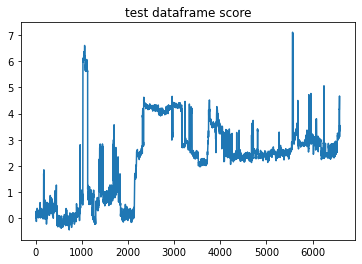

SWATjul9_multi_models_pyod
f1_score: 0.53
accuracy_score: 0.50
precision_score: 0.37
recall_score: 0.93


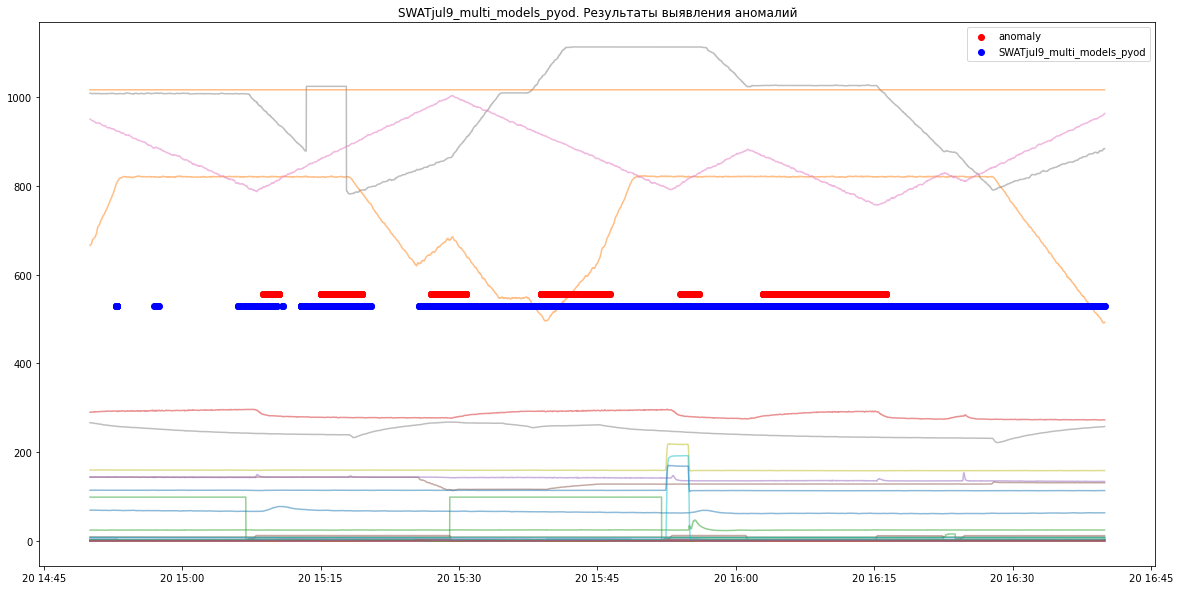

In [44]:
description = f'SWATjul9_multi_models_pyod'

# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=50)]

model = SU_OD(base_estimators=detector_list)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)
model.fit(x_train)
anomalies_predict = model.predict(x_test)

y_test = y_test
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## RNN

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Create sequences with window size 180...
Размеры выборок:
            x_train: (8218, 180, 44)
            x_test: (6421, 180, 44)
            y_test: (6421, 180)
2022-09-23 00:14:38.413428: can't find saved model, fit model...
Epoch 1/10
9/9 [==============================] - 67s 7s/step - loss: 0.9610
Epoch 2/10
9/9 [==============================] - 64s 7s/step - loss: 0.8007
Epoch 3/10
9/9 [==============================] - 64s 7s/step - loss: 0.7716
Epoch 4/10
9/9 [==============================] - 77s 9s/step - loss: 0.7686
Epoch 5/10
9/9 [==============================] - 83s 9s/step - loss: 0.7654
Epoch 6/10
9/9 [==============================] - 82s 9s/step - loss: 0.7611
Epoch 7/10
9/9 [==============================] - 73s 8s/step - loss: 0.7554
Epoch 8/10
9/9 [==============================] - 80s 9s/step - loss: 0.7454
Epoch 9/10
9/9 [==============================] - 73s 8s/step - loss: 0.7283
E

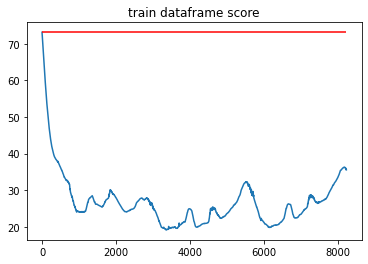

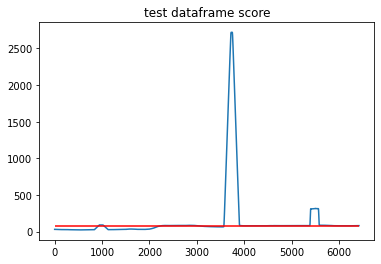

(6421,)
SWATJuj19_rnn_window_180_resample_None
f1_score: 0.46
accuracy_score: 0.50
precision_score: 0.35
recall_score: 0.68


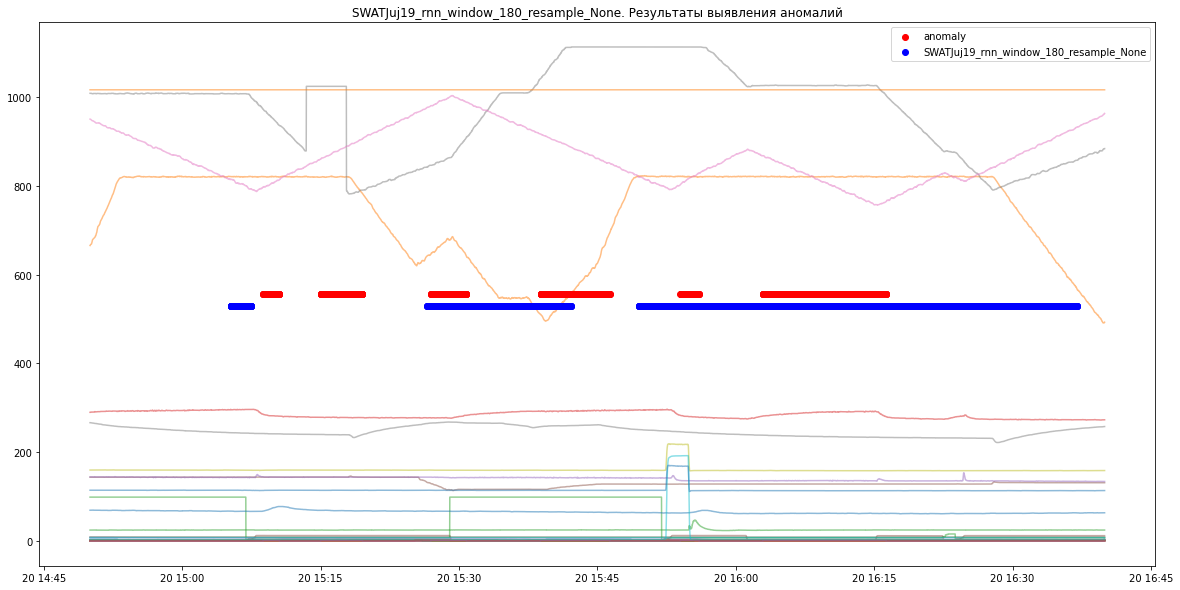

In [18]:
window_size = 180
resample_rate = None

description = f'SWATJuj19_rnn_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = RNN()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      window_size=window_size,  
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

# Сводная таблица

In [19]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format(precision=2).background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
SWATJuj19_rnn_window_30_resample_None,0.14,0.65,0.28,0.10
SWATJuj19_rnn_window_60_resample_None,0.35,0.58,0.33,0.37
SWATJuj19_rnn_window_90_resample_None,0.47,0.62,0.41,0.56
SWATJuj19_rnn_window_120_resample_None,0.46,0.51,0.35,0.68
SWATJuj19_rnn_window_180_resample_None,0.46,0.50,0.35,0.68
